## Example use case of Octrac

In [1]:
import s3fs
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import ocetrac

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

### Import NOAA OISST v2.1 dataset and resample monthly means

In [2]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True, decode_timedelta=True).resample(time='MS').mean()
print(ds)

<xarray.Dataset>
Dimensions:  (time: 478, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>


### Feature thresholding

In [6]:
# Compute values of the monthly threshold defined using the 90th percentile

if ds.anom.chunks:
    ds['anom'] = ds.anom.chunk({'time': -1})
    
threshold = ds.anom.quantile(.9, dim=('time'))
features_ssta = ds.anom.where(ds.anom>=threshold, other=np.nan).isel(zlev=0)


In [9]:
%%time 
# Just take the first 100 time steps
features_ssta= features_ssta[:100,:,:].load()

CPU times: user 5min 13s, sys: 1min 33s, total: 6min 47s
Wall time: 6min 6s


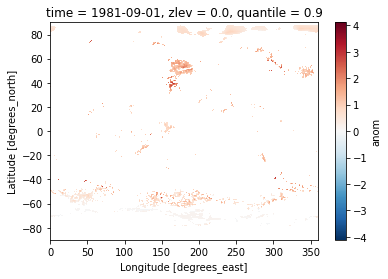

In [10]:
features_ssta.isel(time=0).plot()

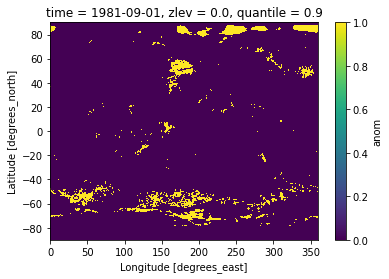

In [11]:
# Binary conversion
binary_out = np.isfinite(features_ssta)
binary_out.isel(time=0).plot()

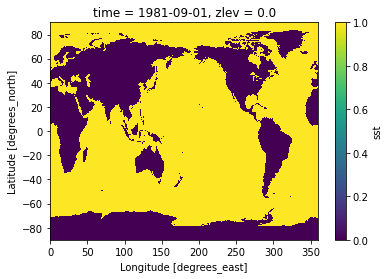

In [12]:
mask = np.isfinite(ds.sst.isel(time=0, zlev=0))
mask.plot()

In [13]:
%%time
Tracker = ocetrac.Tracker(binary_out, mask, radius=8, min_size_quartile=0.75, timedim='time', xdim='lon', ydim='lat', positive=True)
blobs = Tracker.track()

minimum area: 1845.75
inital objects identified 	 1950
final objects tracked 	 198
CPU times: user 1min 38s, sys: 23.5 s, total: 2min 2s
Wall time: 2min 15s


In [14]:
blobs.attrs

{'inital objects identified': 1950,
 'final objects tracked': 198,
 'radius': 8,
 'size quantile threshold': 0.75,
 'min area': 1845.75,
 'percent area reject': 0.20561608954566832,
 'percent area accept': 0.7943839104543317}

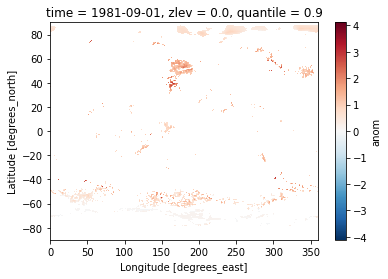

In [15]:
features_ssta.isel(time=0).plot()

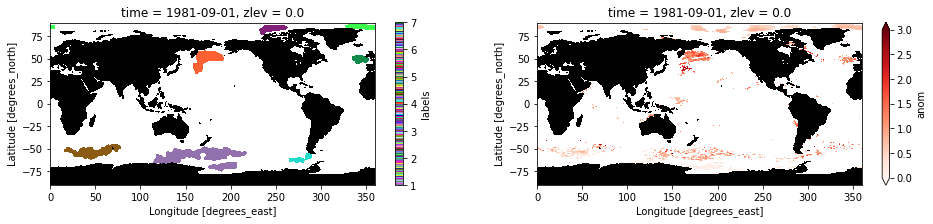

In [16]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

plt.figure(figsize=(16,3))
ax1 = plt.subplot(121);blobs.isel(time=0).plot(cmap= cm)
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax1.set_aspect('equal')
ax2 = plt.subplot(122); features_ssta.isel(time=0).plot(cmap='Reds', vmin=0, vmax=3);
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax2.set_aspect('equal');

In [17]:
mo = Tracker._morphological_operations()

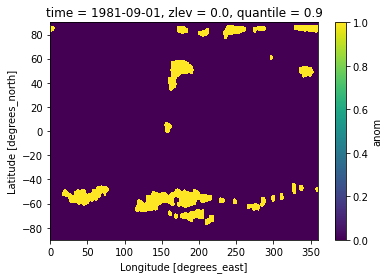

In [18]:
mo.isel(time=0).plot()